In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
import os, random, matplotlib, pickle, yaml
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap
from glob2 import glob

SMALL_SIZE, MEDIUM_SIZE = 9, 12

<h1><font color="blue">Import Data</font></h1>

In [3]:
result_path = "results/round3_antennae"
with open(f"{result_path}/INFO.yaml") as f:
    INFO = yaml.load(f, Loader=yaml.FullLoader)
    INFO_values = list(INFO.values())
    INFO_values.sort(key=lambda x: x['order'])
    
config_path = "."
with open(f"{config_path}/config.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [4]:
tot_bp, tot_bp_scaled, tot_bp_rotated, tot_body_orientation, tot_angles, tot_rotations, tot_power, tot_embed = [], [], [], [], [], [], [], []
for file in tqdm(INFO_values):
    tot_bp.append( np.load(f"{file['directory']}/bodypoints.npy") )
    tot_bp_scaled.append( np.load(f"{file['directory']}/scaled_bodypoints.npy") )
    tot_bp_rotated.append( np.load(f"{file['directory']}/rotated_bodypoints.npy") )
    tot_body_orientation.append( np.load(f"{file['directory']}/body_orientation_angles.npy") )
    tot_angles.append( np.load(f"{file['directory']}/angles.npy") )
    tot_power.append( np.load(f"{file['directory']}/power.npy") )
    tot_embed.append( np.load(f"{file['directory']}/embeddings.npy") )

tot_bp = np.concatenate(tot_bp)
tot_bp_scaled = np.concatenate(tot_bp_scaled)
tot_bp_rotated = np.concatenate(tot_bp_rotated)
tot_body_orientation = np.concatenate(tot_body_orientation)
tot_angles = np.concatenate(tot_angles)
tot_power = np.concatenate(tot_power, axis=2)
tot_embed = np.concatenate(tot_embed)

In [5]:
num_fr,_,_ = tot_bp_rotated.shape
likelihood = tot_bp_rotated[:,:,2]

In [392]:
data1 = np.ones((100,3))
data2 = np.ones((100,4))
data3 = np.ones((100,9))

In [397]:
np.concatenate([data1, data2, data3], axis=1).shape

(100, 16)

# Understanding the Data

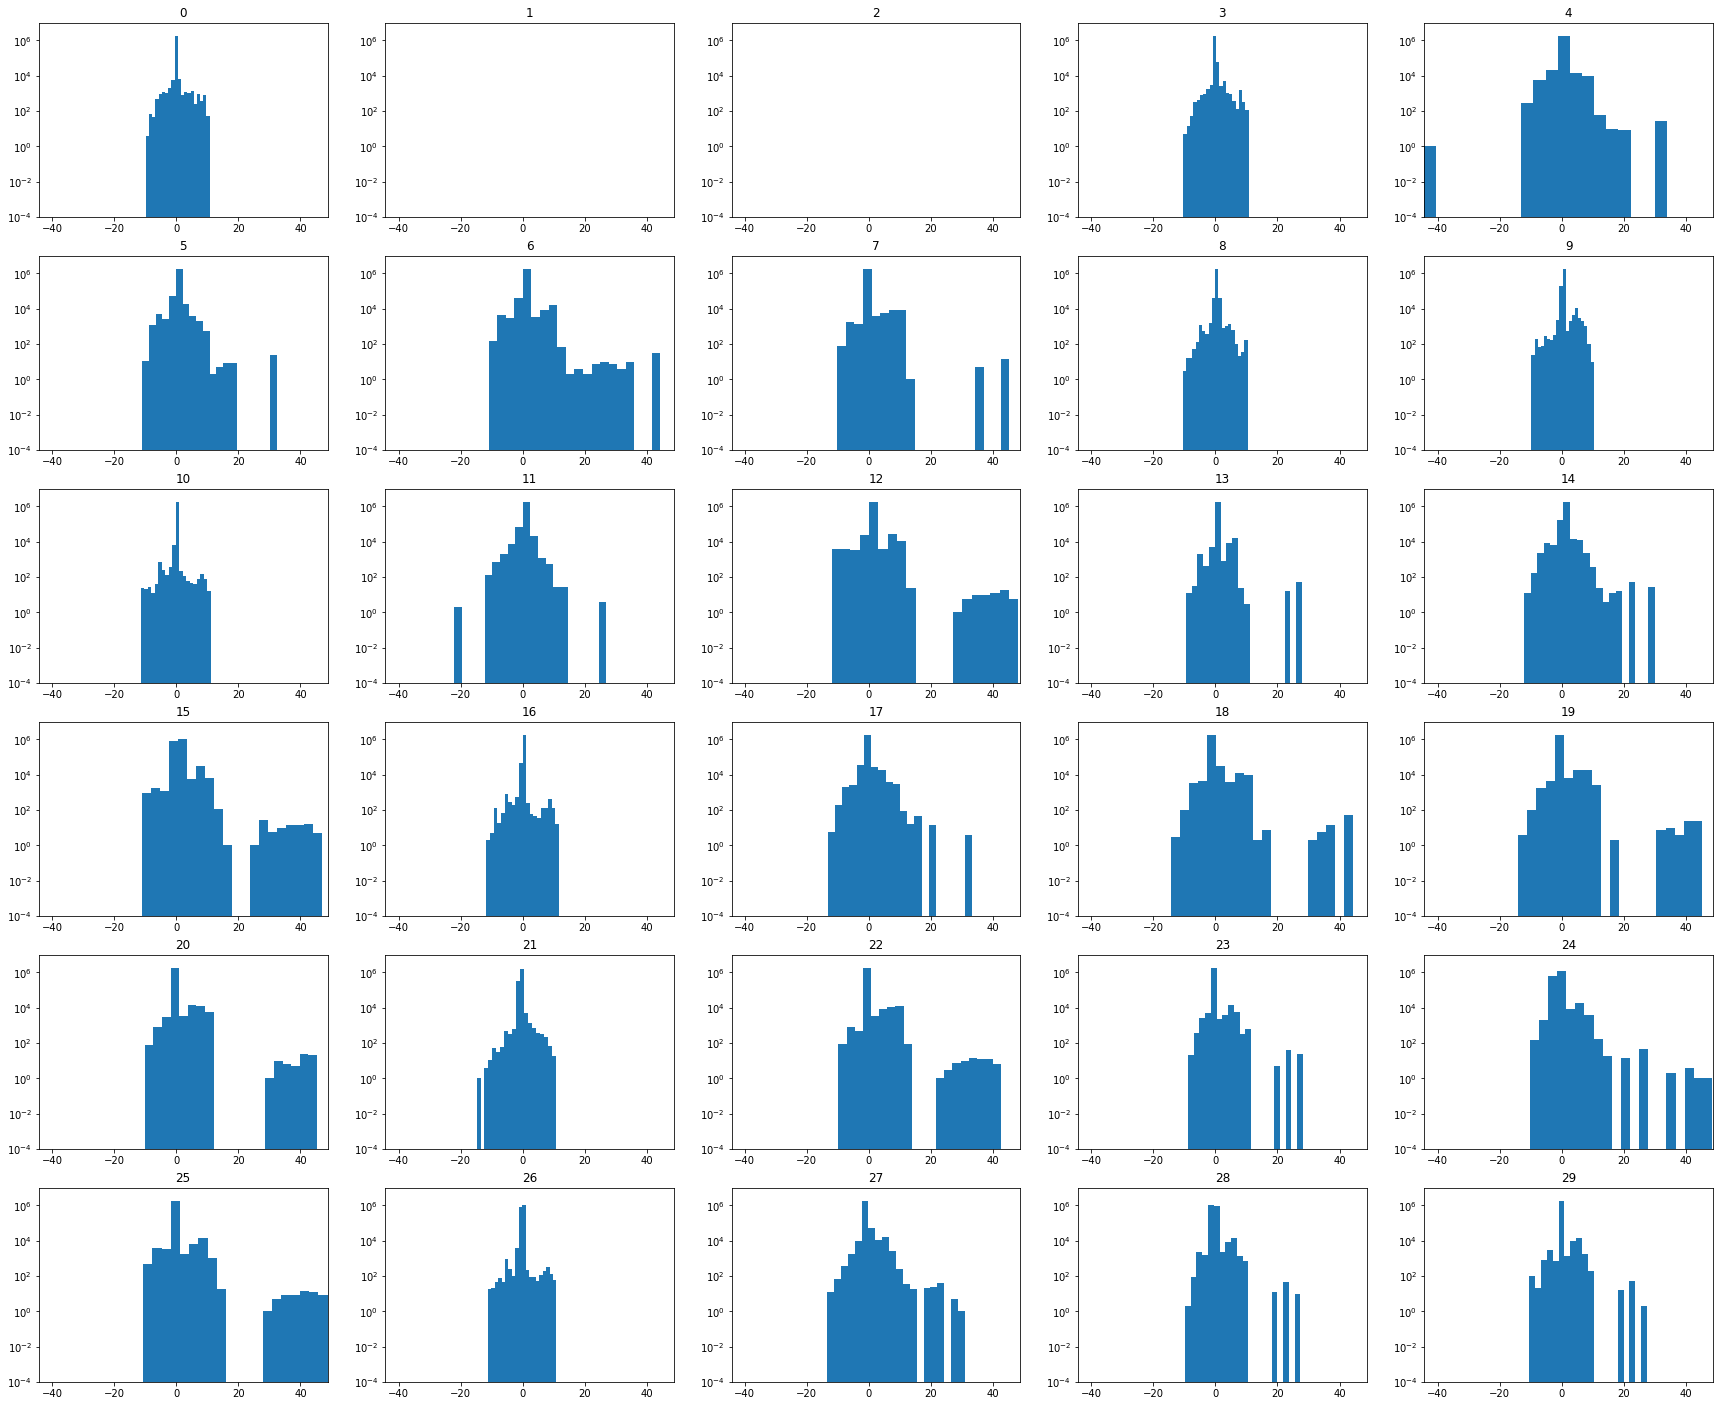

In [33]:
# Distributions of the (x,y) coordinates of the 30 markers

x_min, x_max = np.min(tot_bp_rotated[:,:,0]), np.max(tot_bp_rotated[:,:,0])
fig, ax = plt.subplots(6,5,figsize=(30,25))
for i in range(30):
    ax[i//5,i%5].hist(tot_bp_rotated[:,i,0], 20, log=True)
    ax[i//5,i%5].set(title=i, ylim=(0.0001,10**7), xlim=(x_min, x_max))
plt.show()

y_min, y_max = np.min(tot_bp_rotated[:,:,1]), np.max(tot_bp_rotated[:,:,1])
fig, ax = plt.subplots(6,5,figsize=(30,25))
for i in range(30):
    ax[i//5,i%5].hist(tot_bp_rotated[:,i,1], 20, log=True)
    ax[i//5,i%5].set(title=i, ylim=(0.0001,10**7), xlim=(y_min, y_max))
plt.show()

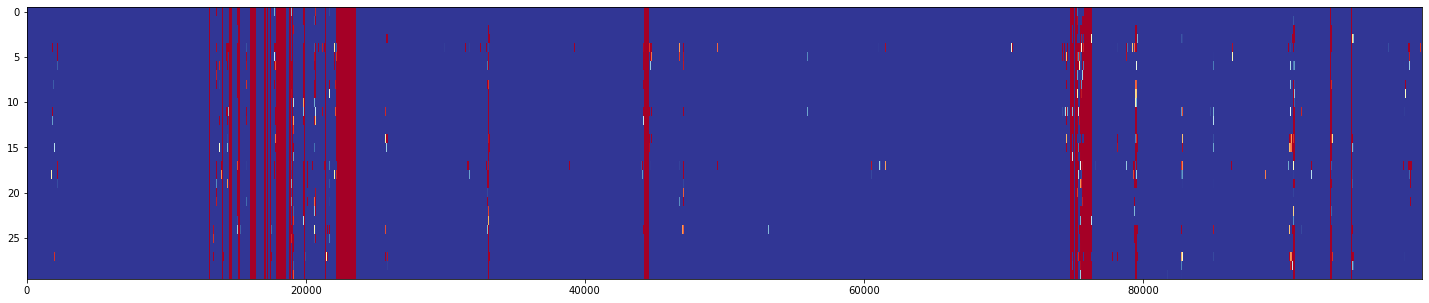

In [37]:
# Likelihood of markers across frames

fig, ax = plt.subplots(figsize=(25,5))
plt.imshow(likelihood[:100000,:].T, cmap='RdYlBu', aspect='auto')
plt.show()

(bad_fr, bad_bp) = np.where(likelihood != 1.0)
print(100*len(np.unique(bad_fr))/num_fr)

/Users/donghur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  after removing the cwd from sys.path.


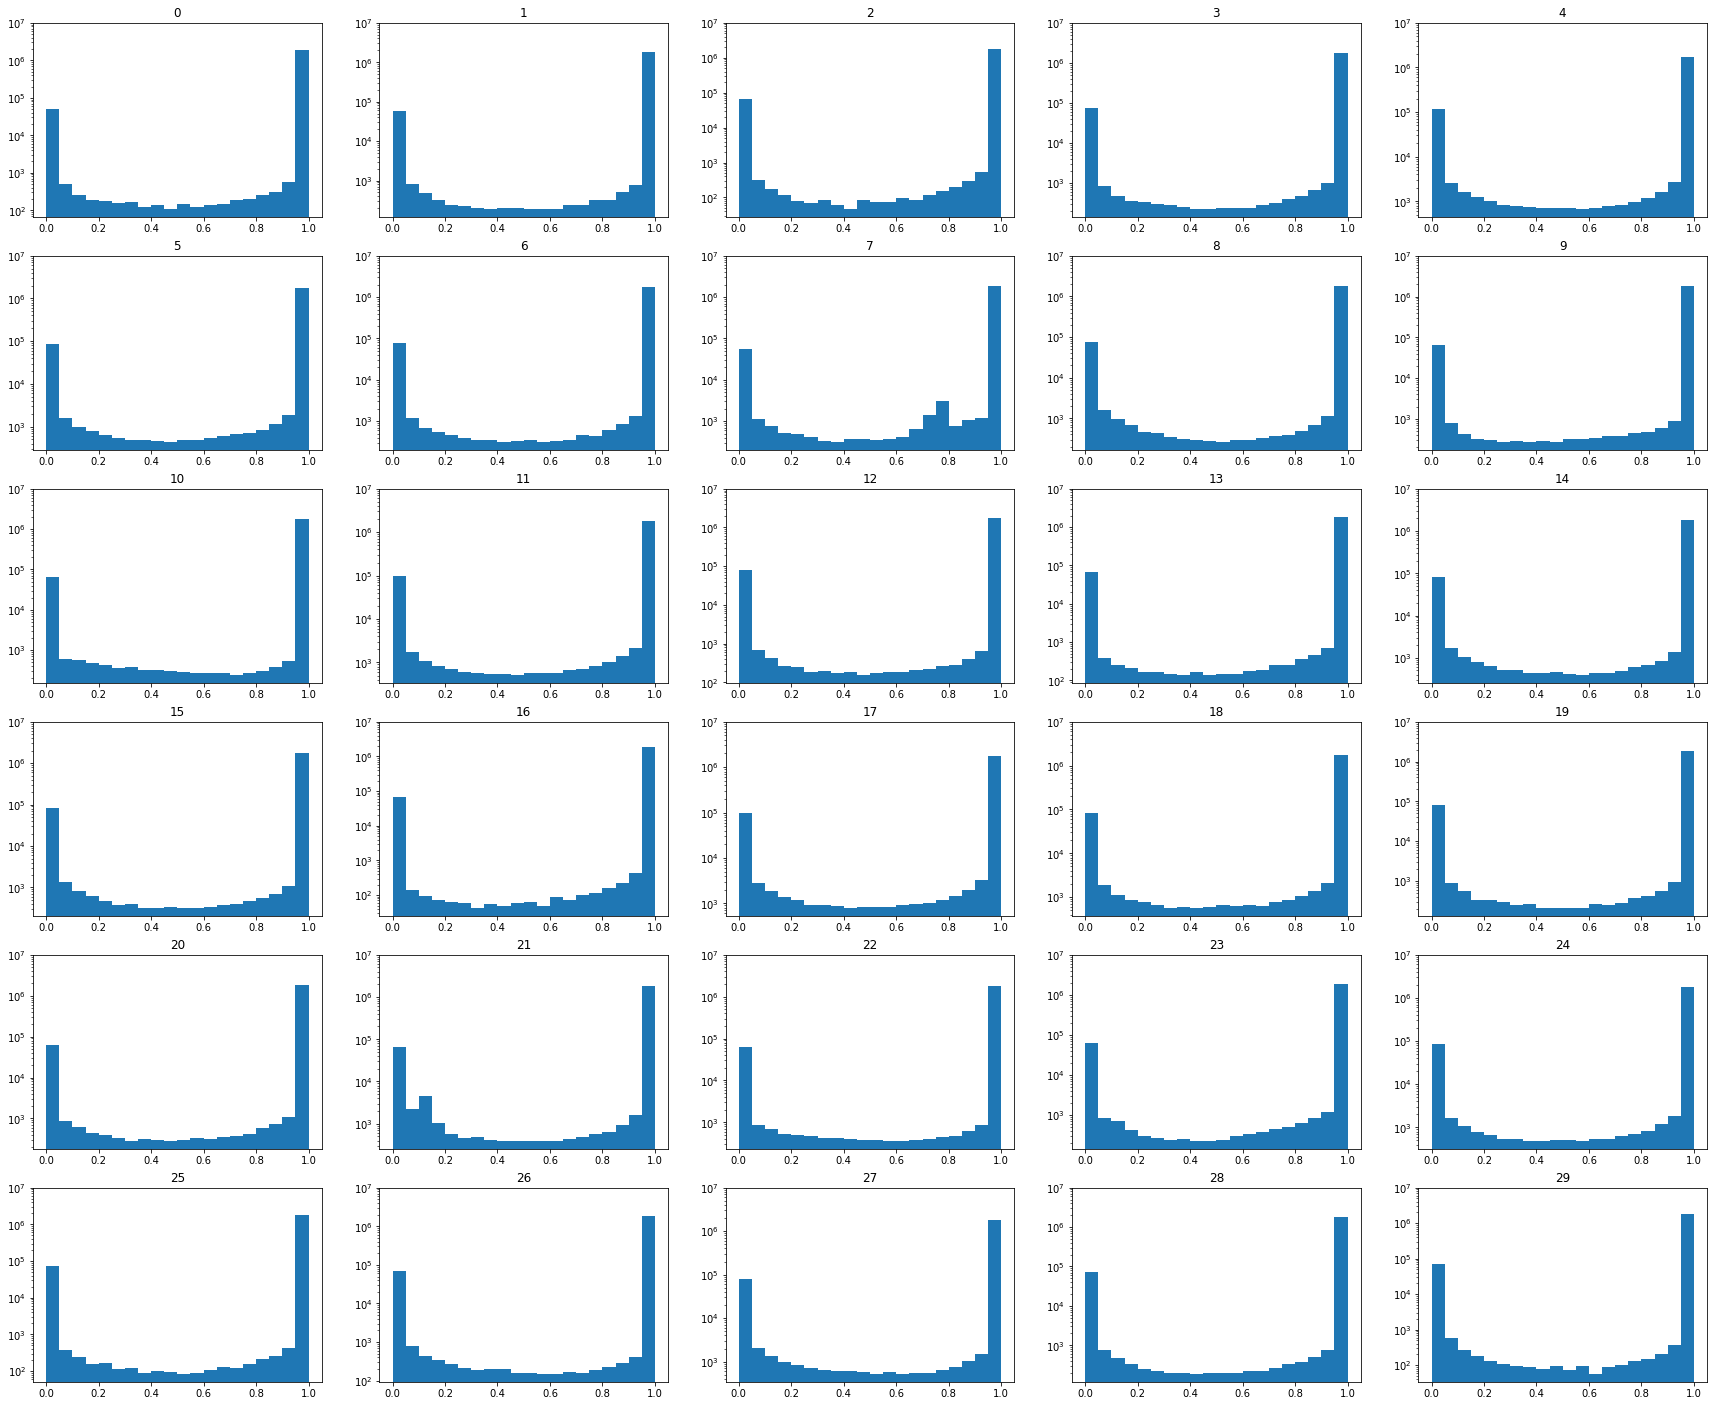

In [41]:
fig, ax = plt.subplots(6,5,figsize=(30,25))
for i in range(30):
    ax[i//5,i%5].hist(likelihood[:,i],20, log=True)
    ax[i//5,i%5].set(title=i, ylim=(0,10**7))
plt.show()

In [42]:
thresh = 0.98
num_bp_thresh = 3

(below_thresh_fr, below_thresh_bp) = np.where(likelihood < thresh)

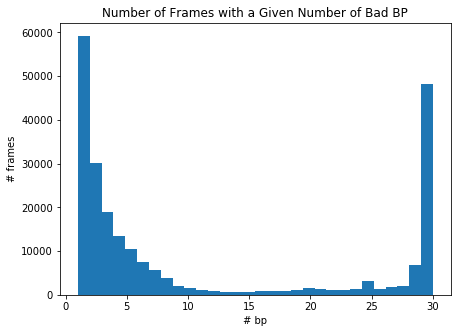

In [44]:
import collections

cnt = collections.Counter(below_thresh_fr)
cnt_array = np.array(list(cnt.items()))

fig, ax = plt.subplots(figsize=(7,5))
ax.hist(cnt_array[:,1], 30)
ax.set(title="Number of Frames with a Given Number of Bad BP", xlabel="# bp", ylabel="# frames")
plt.show()

In [45]:
bad_fr_idx = np.where(cnt_array[:,1] > num_bp_thresh)[0]
bad_fr = cnt_array[bad_fr_idx,0]

In [55]:
# create padding
pad = 20

padded_fr = np.array([ list(range(fr-pad, fr+pad+1)) for fr in bad_fr])
disregard_fr = np.unique(padded_fr.flatten())
disregard_fr = disregard_fr[(disregard_fr >= 0) & (disregard_fr <= len(likelihood))]

good_fr_idx = np.array([True]*len(likelihood))
good_fr_idx[disregard_fr] = False

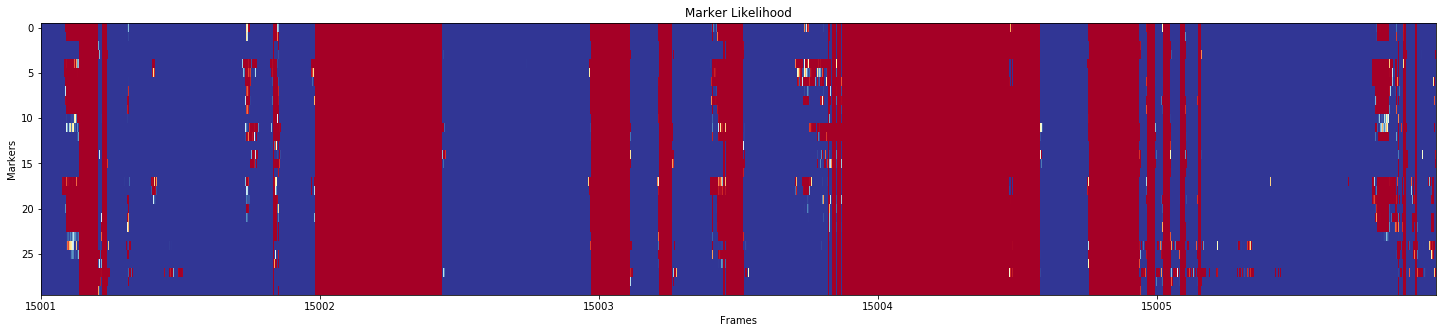

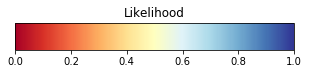

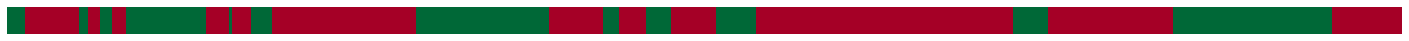

In [612]:
start_fr, stop_fr = 15000, 20000

where_disregard_fr = np.where((disregard_fr>start_fr) & (disregard_fr<stop_fr))[0]
specific_disregard_fr = disregard_fr[where_disregard_fr]-start_fr

disregard_data = np.ones(stop_fr-start_fr)
disregard_data[specific_disregard_fr] = 0

fig, ax = plt.subplots(figsize=(25,5))
im = ax.imshow(likelihood[start_fr:stop_fr,:].T, cmap='RdYlBu', aspect='auto')
ax.set(xticklabels=range(start_fr, stop_fr), title="Marker Likelihood", ylabel="Markers", xlabel="Frames")
plt.show()

fig_cbar, ax_cbar = plt.subplots(figsize=(5,0.5))
fig.colorbar(im, ax_cbar, orientation='horizontal')
ax_cbar.set(title='Likelihood')

fig, ax = plt.subplots(figsize=(25,0.5))
ax.imshow(disregard_data[np.newaxis,:], cmap='RdYlGn', aspect='auto')
plt.axis('off')
plt.show()

# Detect Bad Frames
    1) Check if BP exceeds a certain range
    2) Check if the BP moves to quickly

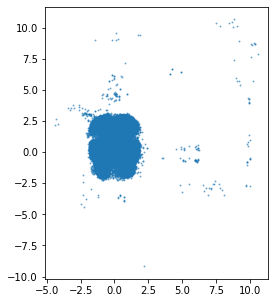

In [74]:
###### Check if BP exceeds a certain range ########
fig, ax = plt.subplots(figsize=(4,5))
ax.scatter(tot_bp_rotated[:10000,:,0], tot_bp_rotated[:10000,:,1], s=1, alpha=0.5)
plt.show()

In [123]:
import seaborn as sns
import pandas as pd

num_fr, num_bp, num_dim = tot_bp_rotated.shape
dummy_data = np.zeros((num_fr, num_bp, num_dim+1))
dummy_data[:,:,0:3] = tot_bp_rotated
dummy_data[:,:,3] = np.arange(0,30, dtype=int)
dummy_reshape = dummy_data.reshape(num_fr*num_bp, num_dim+1)

In [143]:
df = pd.DataFrame(data=dummy_reshape[:1000000,:], columns=['x', 'y', 'l', 'bp'])
df

,x,y,l,bp
0,-4.101705e-02,1.552438,1.0,0.0
1,1.162265e-16,0.938014,1.0,1.0
2,0.000000e+00,0.000000,1.0,2.0
3,1.150814e-01,-0.826269,1.0,3.0
4,8.277885e-01,2.792735,1.0,4.0
...,...,...,...,...
999995,7.823860e-01,2.017820,1.0,5.0
999996,4.117377e-01,1.749705,1.0,6.0
999997,2.046890e-01,1.417851,1.0,7.0
999998,3.614942e-01,0.932047,1.0,8.0


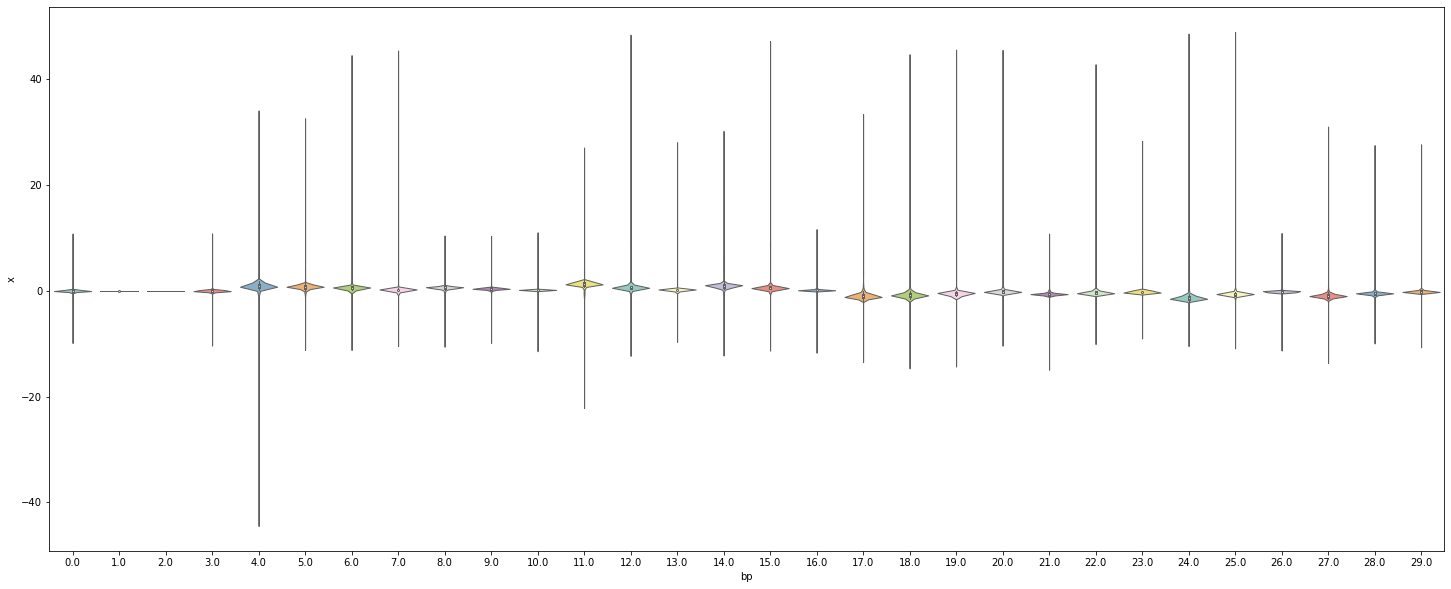

In [137]:
import seaborn as sns
import pandas as pd

fig, ax = plt.subplots(figsize=(25, 10))
sns.violinplot(x='bp', y='x', data=df, palette="Set3", bw=.2, cut=1, linewidth=1, scale='width')
plt.show()

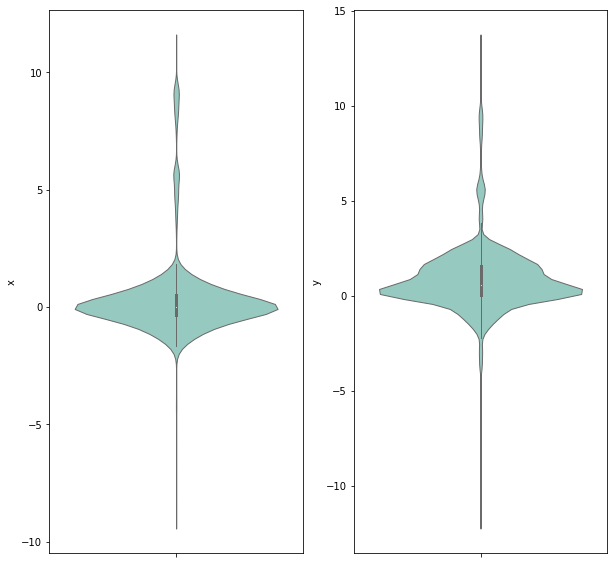

In [147]:
fig, ax = plt.subplots(1,2,figsize=(10, 10))
sns.violinplot(y='x', data=df, palette="Set3", bw=.2, cut=1, linewidth=1, scale='width', ax=ax[0])
sns.violinplot(y='y', data=df, palette="Set3", bw=.2, cut=1, linewidth=1, scale='width', ax=ax[1])
plt.show()

In [330]:
# measure range
x_bp = tot_bp_rotated[:,:,0]
y_bp = tot_bp_rotated[:,:,1]
x_mean, x_std = np.mean(x_bp), np.std(x_bp)
y_mean, y_std = np.mean(y_bp), np.std(y_bp)

x_bound = np.array([x_mean-2.5*x_std, x_mean+2.5*x_std])
y_bound = np.array([y_mean-2.5*y_std, y_mean+2.5*y_std])


In [201]:
x_condition = (tot_bp_rotated[:,:,0]>x_bound[1]) | (tot_bp_rotated[:,:,0]<x_bound[0])
y_condition = (tot_bp_rotated[:,:,1]>y_bound[1]) | (tot_bp_rotated[:,:,1]<y_bound[0])

(out_bound_fr, out_bound_bp) = np.where(x_condition | y_condition)
tot_bp_rotated[out_bound_fr,out_bound_bp,2] = 0

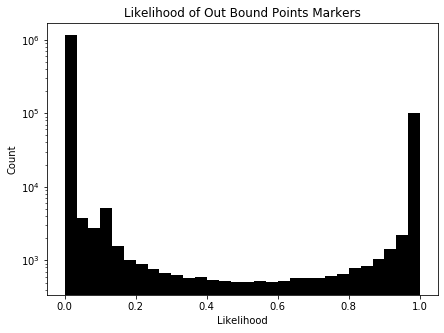

In [220]:
out_bound_likelihood = tot_bp_rotated[out_bound_fr,out_bound_bp,2]
fig, ax = plt.subplots(figsize=(7,5))
ax.hist(out_bound_likelihood, 30, log=True, color='k')
ax.set(title="Likelihood of Out Bound Points Markers", xlabel="Likelihood", ylabel="Count")
plt.show()

In [174]:
(good_fr, good_bp) = np.where(tot_bp_rotated[:,:,2]>0.99)
good_fr = np.unique(good_fr)

In [175]:
good_fr.shape

(1834076,)

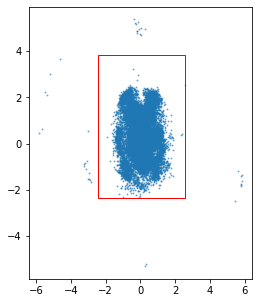

In [331]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(4,5))
ax.scatter(tot_bp_rotated[1827681:1827681+1000,:,0], tot_bp_rotated[1827681:1827681+1000,:,1], s=1, alpha=0.5)
rect = patches.Rectangle((x_bound[0], y_bound[0]), x_bound[1]-x_bound[0], y_bound[1]-y_bound[0],linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

In [343]:
#### Check if the BP moves to quickly #######
velocity_threshold = 2

In [344]:
marker_change = np.diff(tot_bp_rotated[:,:,0:2], axis=0)**2
marker_velocity = np.sqrt(np.sum(marker_change, axis=2))
(above_velocity_fr, above_velocity_marker) = np.where(marker_velocity > velocity_threshold)
# DLC_data[above_velocity_fr, above_velocity_marker, 2] = 0

In [353]:
above_velocity_fr[above_velocity_marker == 4][:5]

array([1756, 1760, 1762, 1767, 1783])

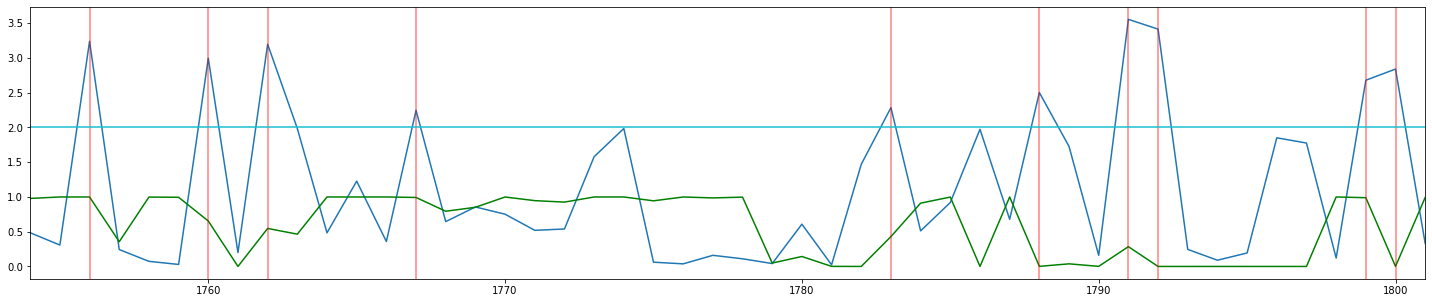

In [381]:
specific_fr = np.unique(above_velocity_fr)

fig, ax = plt.subplots(figsize=(25,5))
ax.plot(range(1754,1802), marker_velocity[1754:1802,4])
ax.plot(range(1754,1802), tot_bp_rotated[1754:1802,4,2],'g')
for i in above_velocity_fr[above_velocity_marker == 4][:10]:
    ax.axvline(x=i, c='r', alpha=0.5)
ax.axhline(velocity_threshold, c='tab:cyan')
ax.set(xlim=(1754,1801))
plt.show()

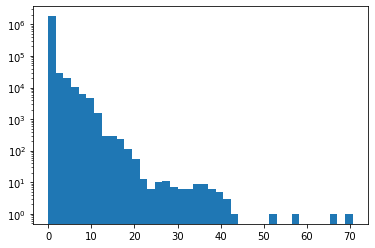

In [387]:
plt.hist(marker_velocity[:,4], 40, log=True)
plt.show()

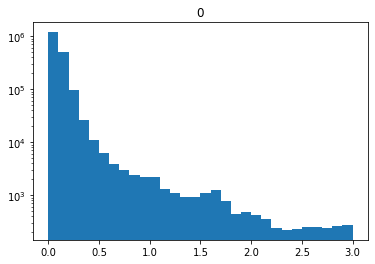

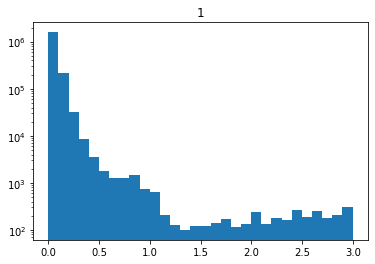

/Users/donghur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  """


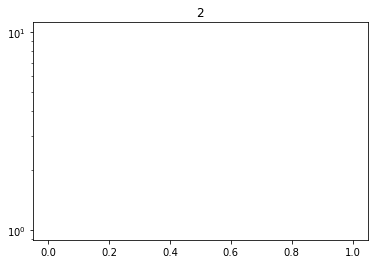

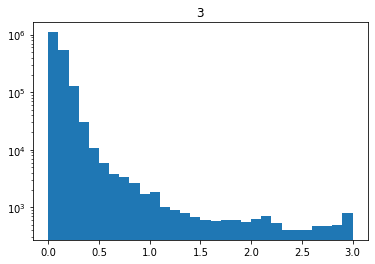

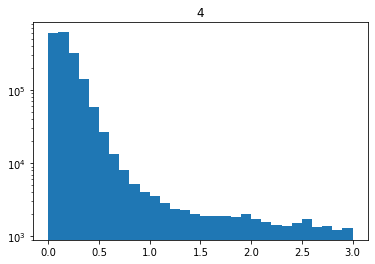

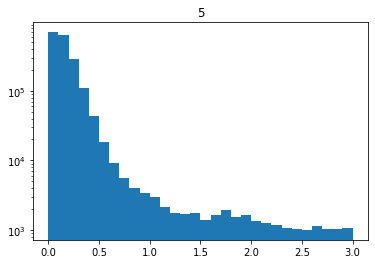

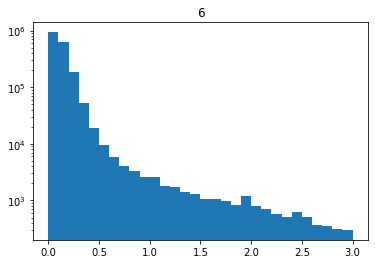

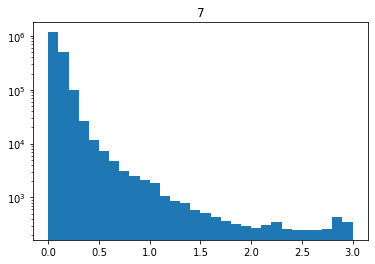

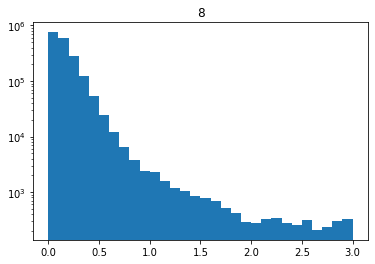

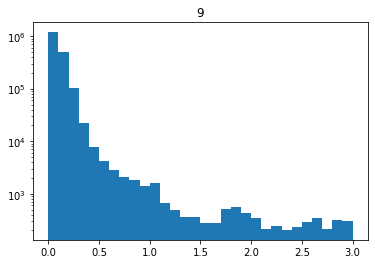

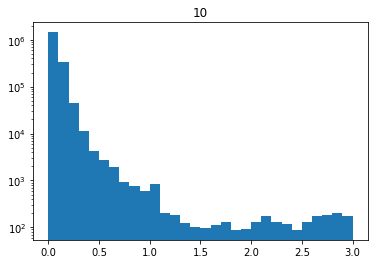

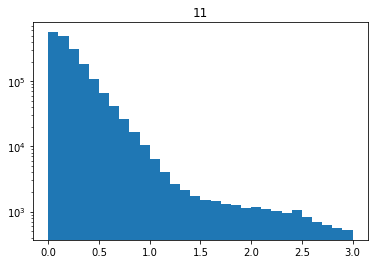

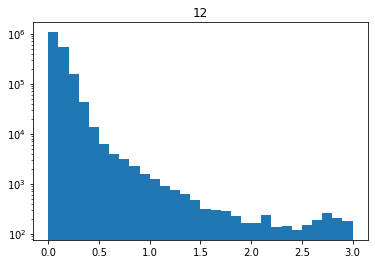

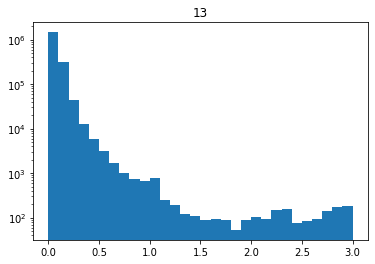

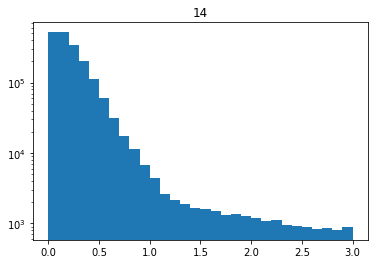

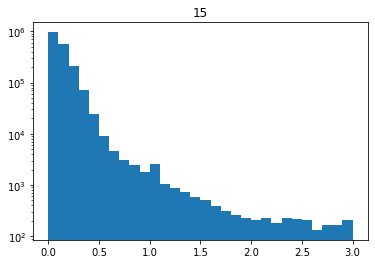

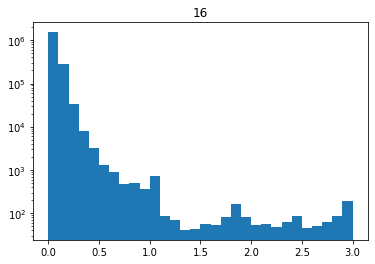

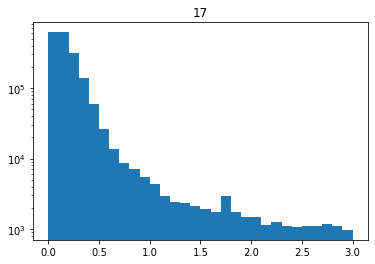

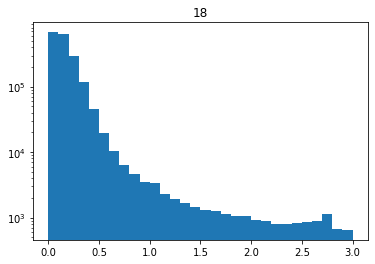

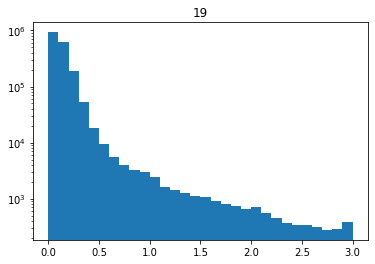

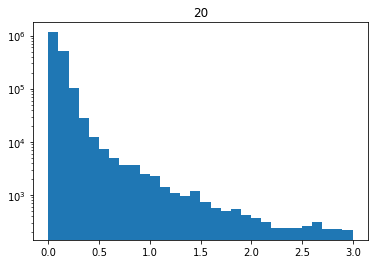

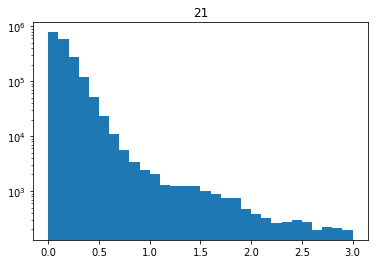

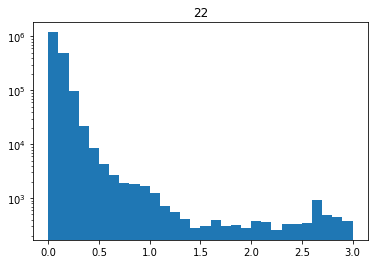

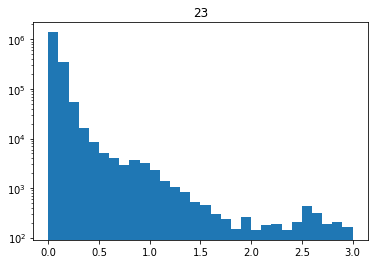

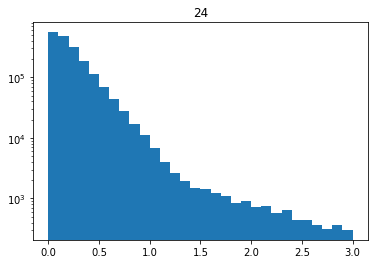

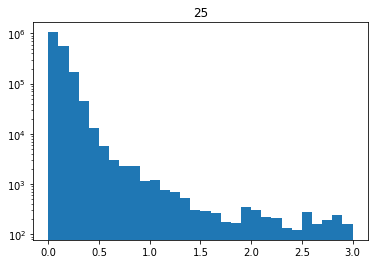

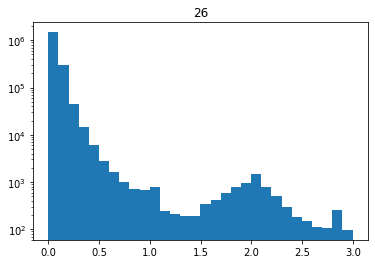

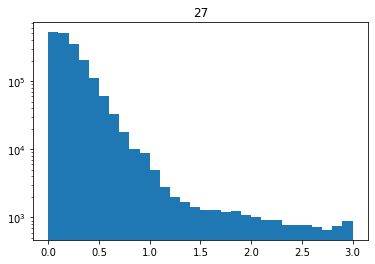

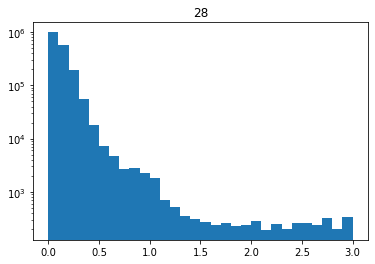

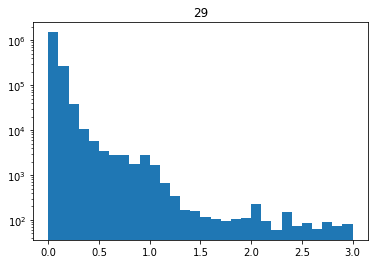

In [302]:
speed_bound = [0,3]
good_fr, good_marker = np.where((marker_dist>speed_bound[0]) & (marker_dist<speed_bound[1]))

for i in range(30):
    good_fr_i = good_fr[good_marker==i]
    plt.hist(marker_dist[good_fr_i,i], 30, log=True)
    plt.title(i)
    plt.show()

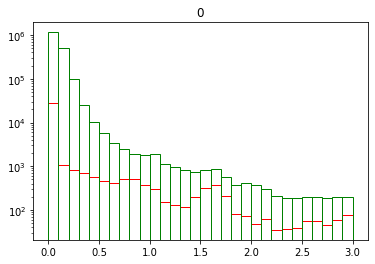

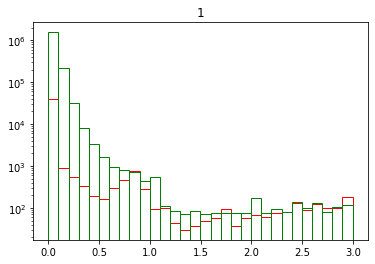

/Users/donghur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  import sys
/Users/donghur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  


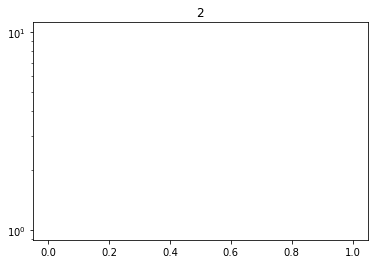

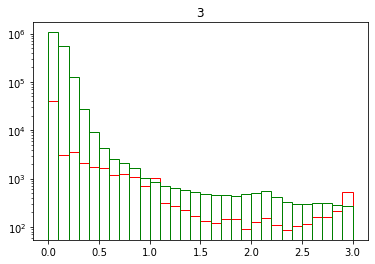

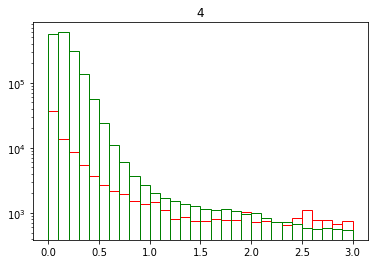

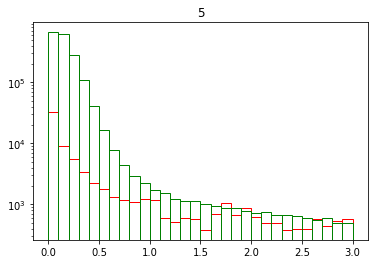

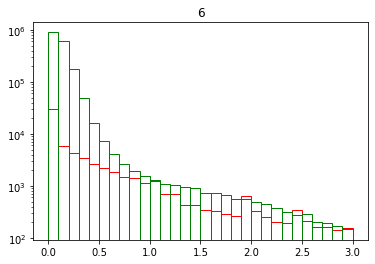

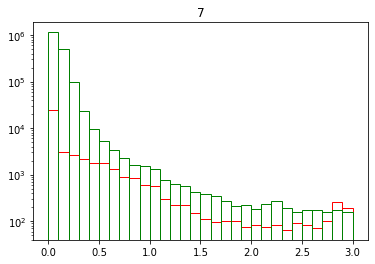

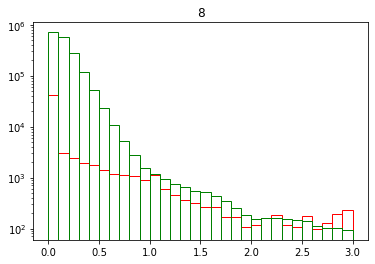

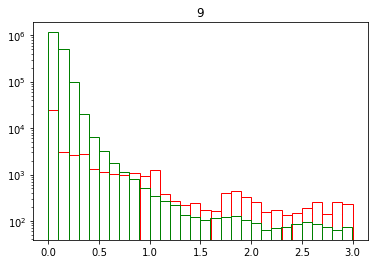

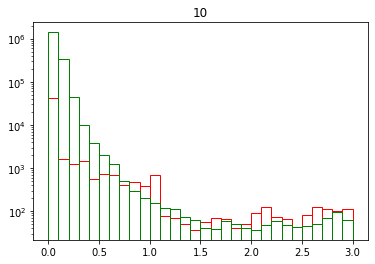

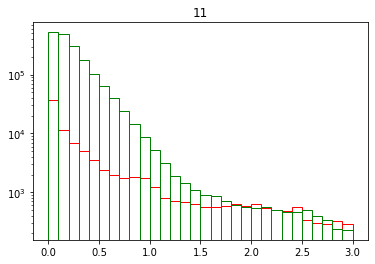

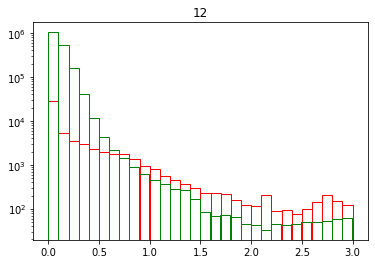

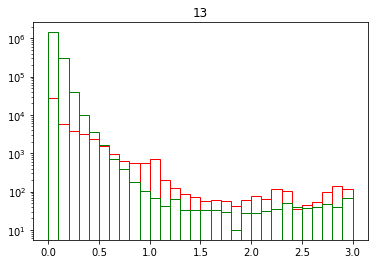

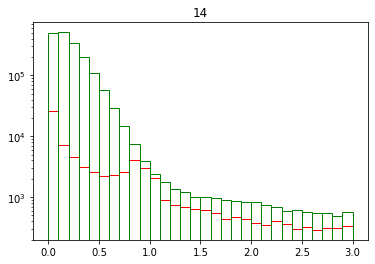

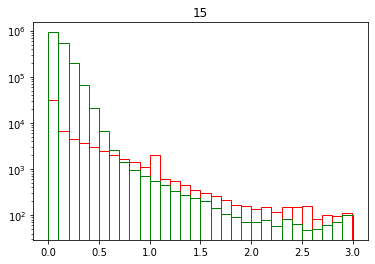

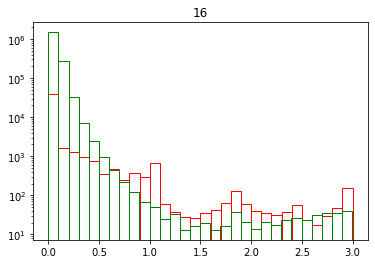

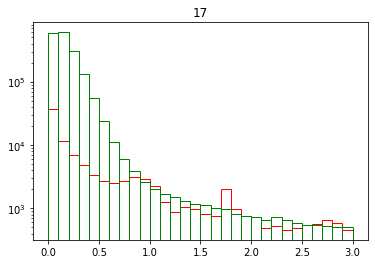

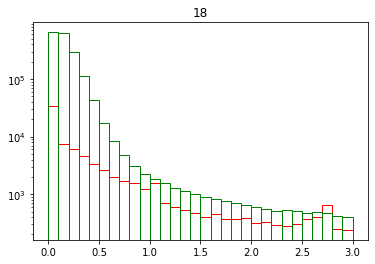

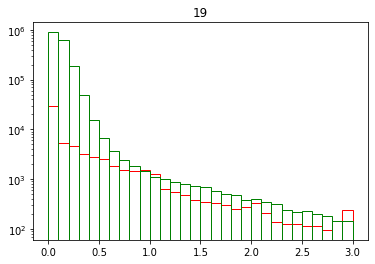

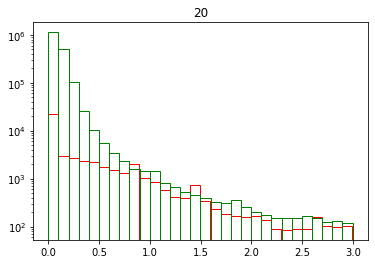

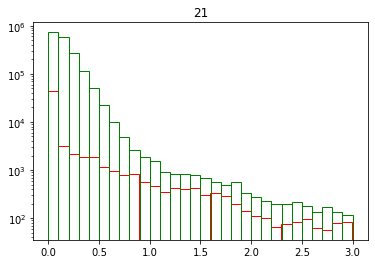

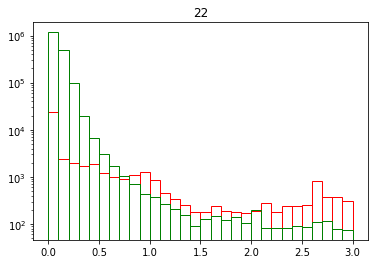

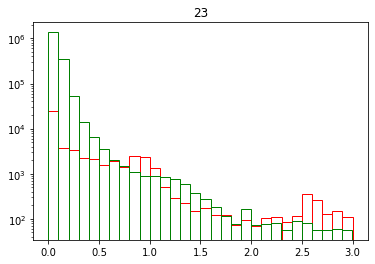

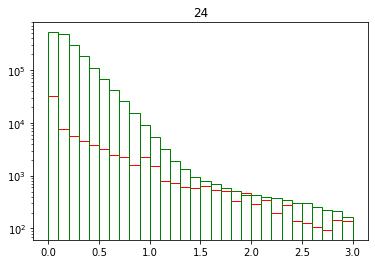

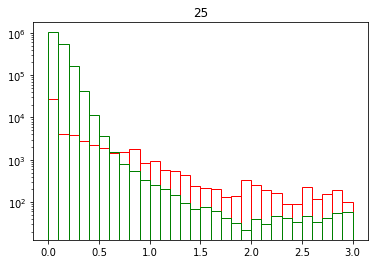

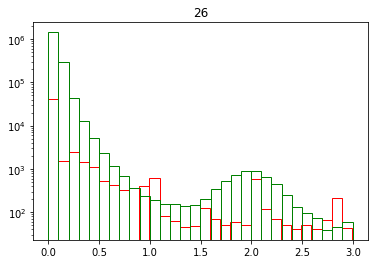

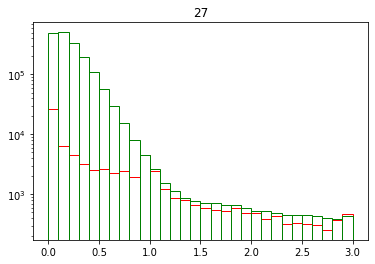

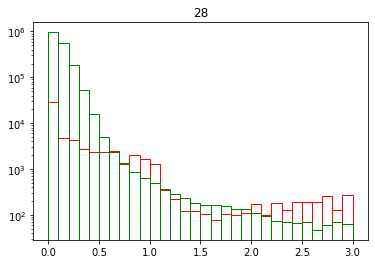

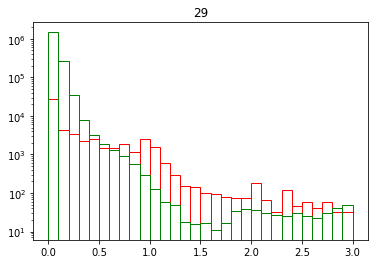

In [321]:
speed_bound = [0,3]

likelihood = tot_bp_rotated[:,:,2]
(bad_fr, bad_marker) = np.where((likelihood[1:] <= 0.95) & (marker_dist>speed_bound[0]) & (marker_dist<speed_bound[1]))
(good_fr, good_marker) = np.where((likelihood[1:] > 0.95) & (marker_dist>speed_bound[0]) & (marker_dist<speed_bound[1]))

for i in range(30):
    bad_fr_i = bad_fr[bad_marker==i]
    good_fr_i = good_fr[good_marker==i]
    
    plt.hist(marker_dist[bad_fr_i,i], 30, log=True, edgecolor='r', alpha=1, fill=None)
    plt.hist(marker_dist[good_fr_i,i], 30, log=True, edgecolor='g', alpha=1, fill=None)
    
    plt.title(i)
    plt.show()

<h1><font color="blue">Per-Marker</font></h1>

Cartesian Velocity Component
* x and y velocity for each body point

In [6]:
print(f"tot_bp shape: {tot_bp.shape}")
print(f"tot_bp_scaled shape: {tot_bp_scaled.shape}")
print(f"tot_bp_rotated shape: {tot_bp_rotated.shape}")
print(f"tot_angles shape: {tot_angles.shape}")
print(f"tot_power shape: {tot_power.shape}")
print(f"tot_embed shape: {tot_embed.shape}")

tot_bp shape: (1883492, 30, 3)
tot_bp_scaled shape: (1883492, 30, 3)
tot_bp_rotated shape: (1883492, 30, 3)
tot_angles shape: (1883492, 4, 2)
tot_power shape: (4, 21, 1883492)
tot_embed shape: (1883492, 3)


In [10]:
start_fr = 50000
N_dummy = 50000

dummy_bp = tot_bp[start_fr:start_fr+N_dummy,:,0:2]
dummy_bp_rotate = tot_bp_rotated[:N_dummy,:,0:2]

In [12]:
skeleton = [
    [0,1,2,3],
    [4,5,6,7],
    [8,9,10],
    [11,12,13],
    [14,15,16],
    [17,18,19,20],
    [21,22,23],
    [24,25,26],
    [27,28,29]
]

skeleton_color=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive', 'tab:cyan']

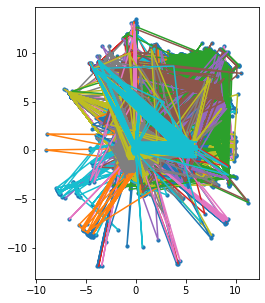

In [10]:
fig_bp_temp, ax_bp_temp = plt.subplots(figsize=(4,5))
ax_bp_temp.scatter(dummy_bp_rotate[:,:,0], dummy_bp_rotate[:,:,1], s=10, alpha=1)
for skeleton_i in skeleton:
    ax_bp_temp.plot(dummy_bp_rotate[:,skeleton_i,0], dummy_bp_rotate[:,skeleton_i,1])
plt.show()

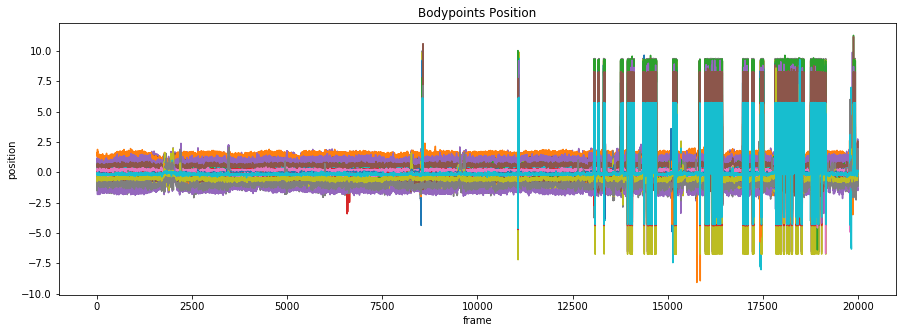

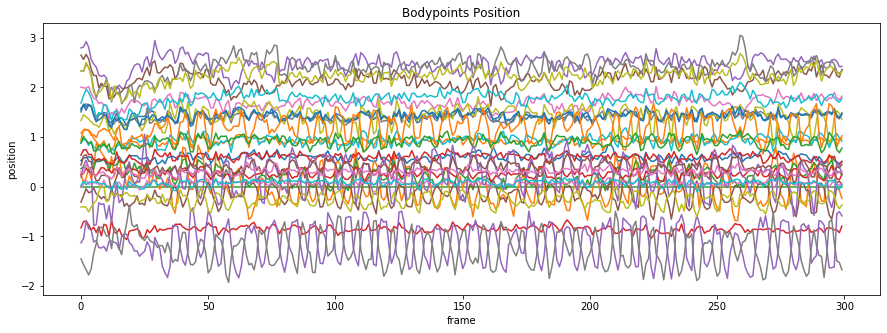

In [11]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(dummy_bp_rotate[:,:,0])
ax.set(xlabel="frame", ylabel="position", title="Bodypoints Position")
plt.show()

f_start, f_stop = 0,300

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(dummy_bp_rotate[f_start:f_stop,:,1])
ax.set(xlabel="frame", ylabel="position", title="Bodypoints Position")
plt.show()

# Perform PCA before UMAP

In [13]:
from sklearn.decomposition import PCA

In [22]:
num_fr, num_bp, num_comp = dummy_bp_rotate.shape
reshaped_bp = dummy_bp_rotate.reshape(num_fr, num_bp*num_comp)

pca = PCA(n_components=5, svd_solver='full')
pca.fit(reshaped_bp.T)
# pca.components_

PCA(n_components=5, svd_solver='full')

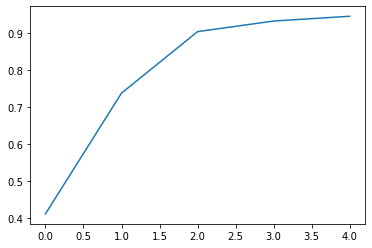

In [23]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)
plt.show()

In [ ]:
import umap

embed = umap.UMAP(n_neighbors=100, n_epochs=100, min_dist=0.1,
                  init="spectral", learning_rate=1.5).fit_transform( pca.components_.T )

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(embed[:,0], embed[:,1], s=1, alpha=0.1)
ax.set(title="Postural Embedding")
plt.show()

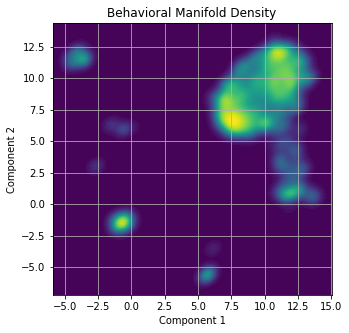

In [131]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.kdeplot(x=embed[:,0], y=embed[:,1], 
            shade=True, thresh=0, gridsize=100, bw_adjust=0.5,
            levels=100, cmap='viridis',
            cbar=False, ax=ax)
ax.set(xlabel='Component 1', ylabel='Component 2', title="Behavioral Manifold Density", facecolor='#440054')
ax.grid(which="major")
plt.show()

In [132]:
import hdbscan
from sklearn.utils import shuffle

In [133]:
# hdbscan clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=100, 
                            min_samples=50,
                            cluster_selection_epsilon=0,
                            cluster_selection_method="leaf",
                            memory="memory"
                           ).fit(embed[:,:])
# parameters
num_clusters = np.max(clusterer.labels_)+1
outlier_pts = (clusterer.labels_ == -1)
labeled_pts = (clusterer.labels_ != -1)

print(f"Frac Outlier: {len(np.where(outlier_pts)[0])/len(clusterer.labels_)}")
print(f"# Clusters: {num_clusters}")

# cmap: coloring
color_palette = sns.color_palette('rainbow', num_clusters)
color_palette = shuffle(color_palette)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = np.array([sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)])

Frac Outlier: 0.61035
# Clusters: 34


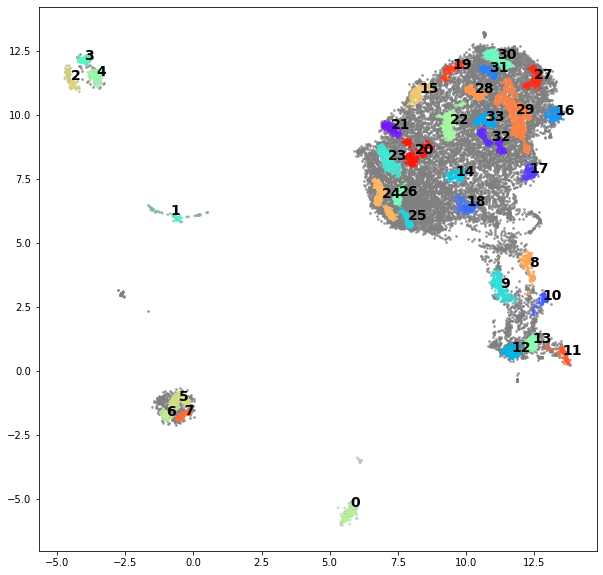

In [134]:
fig, ax = plt.subplots(figsize=(10,10))

# cluster colors
ax.scatter(embed[outlier_pts,0], embed[outlier_pts,1], 
           c="gray", s=3, alpha=0.7)
ax.scatter(embed[labeled_pts,0], embed[labeled_pts,1], 
           c=cluster_member_colors[labeled_pts], s=3, alpha=0.7)

# numbering
cluster_mean = []
for i in tqdm(range(num_clusters)):
    idx = (clusterer.labels_==i)
    ax.annotate(i, np.mean(embed[idx,:], axis=0), fontsize=14, fontweight='bold')
    cluster_mean.append(np.mean(embed[idx,:], axis=0).tolist())
cluster_mean = np.array(cluster_mean)

plt.show()

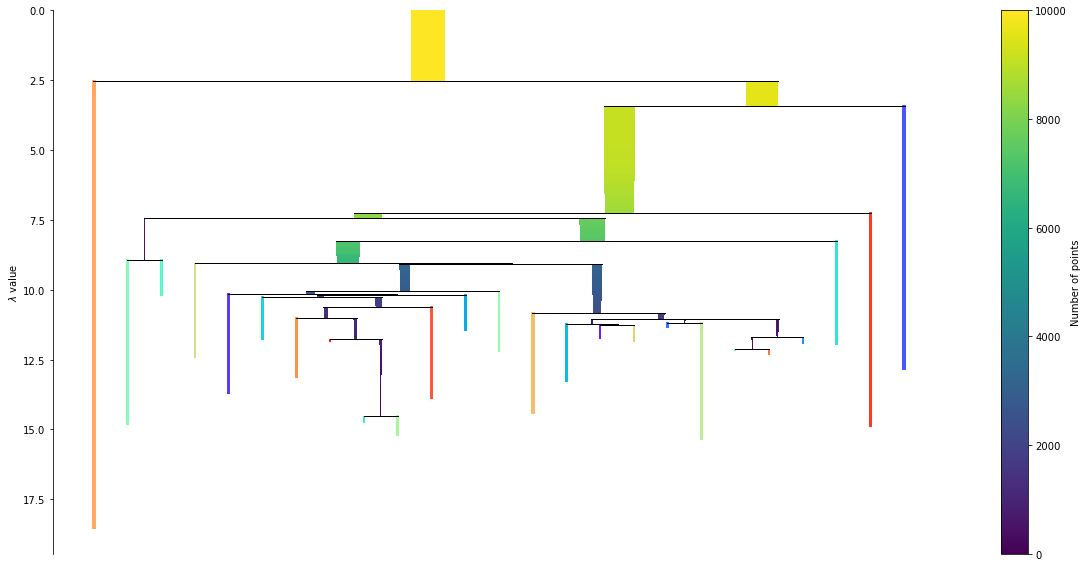

In [88]:
fig, ax = plt.subplots(figsize=(20,10))
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=color_palette,
                              axis=ax)

In [142]:
1%6

1

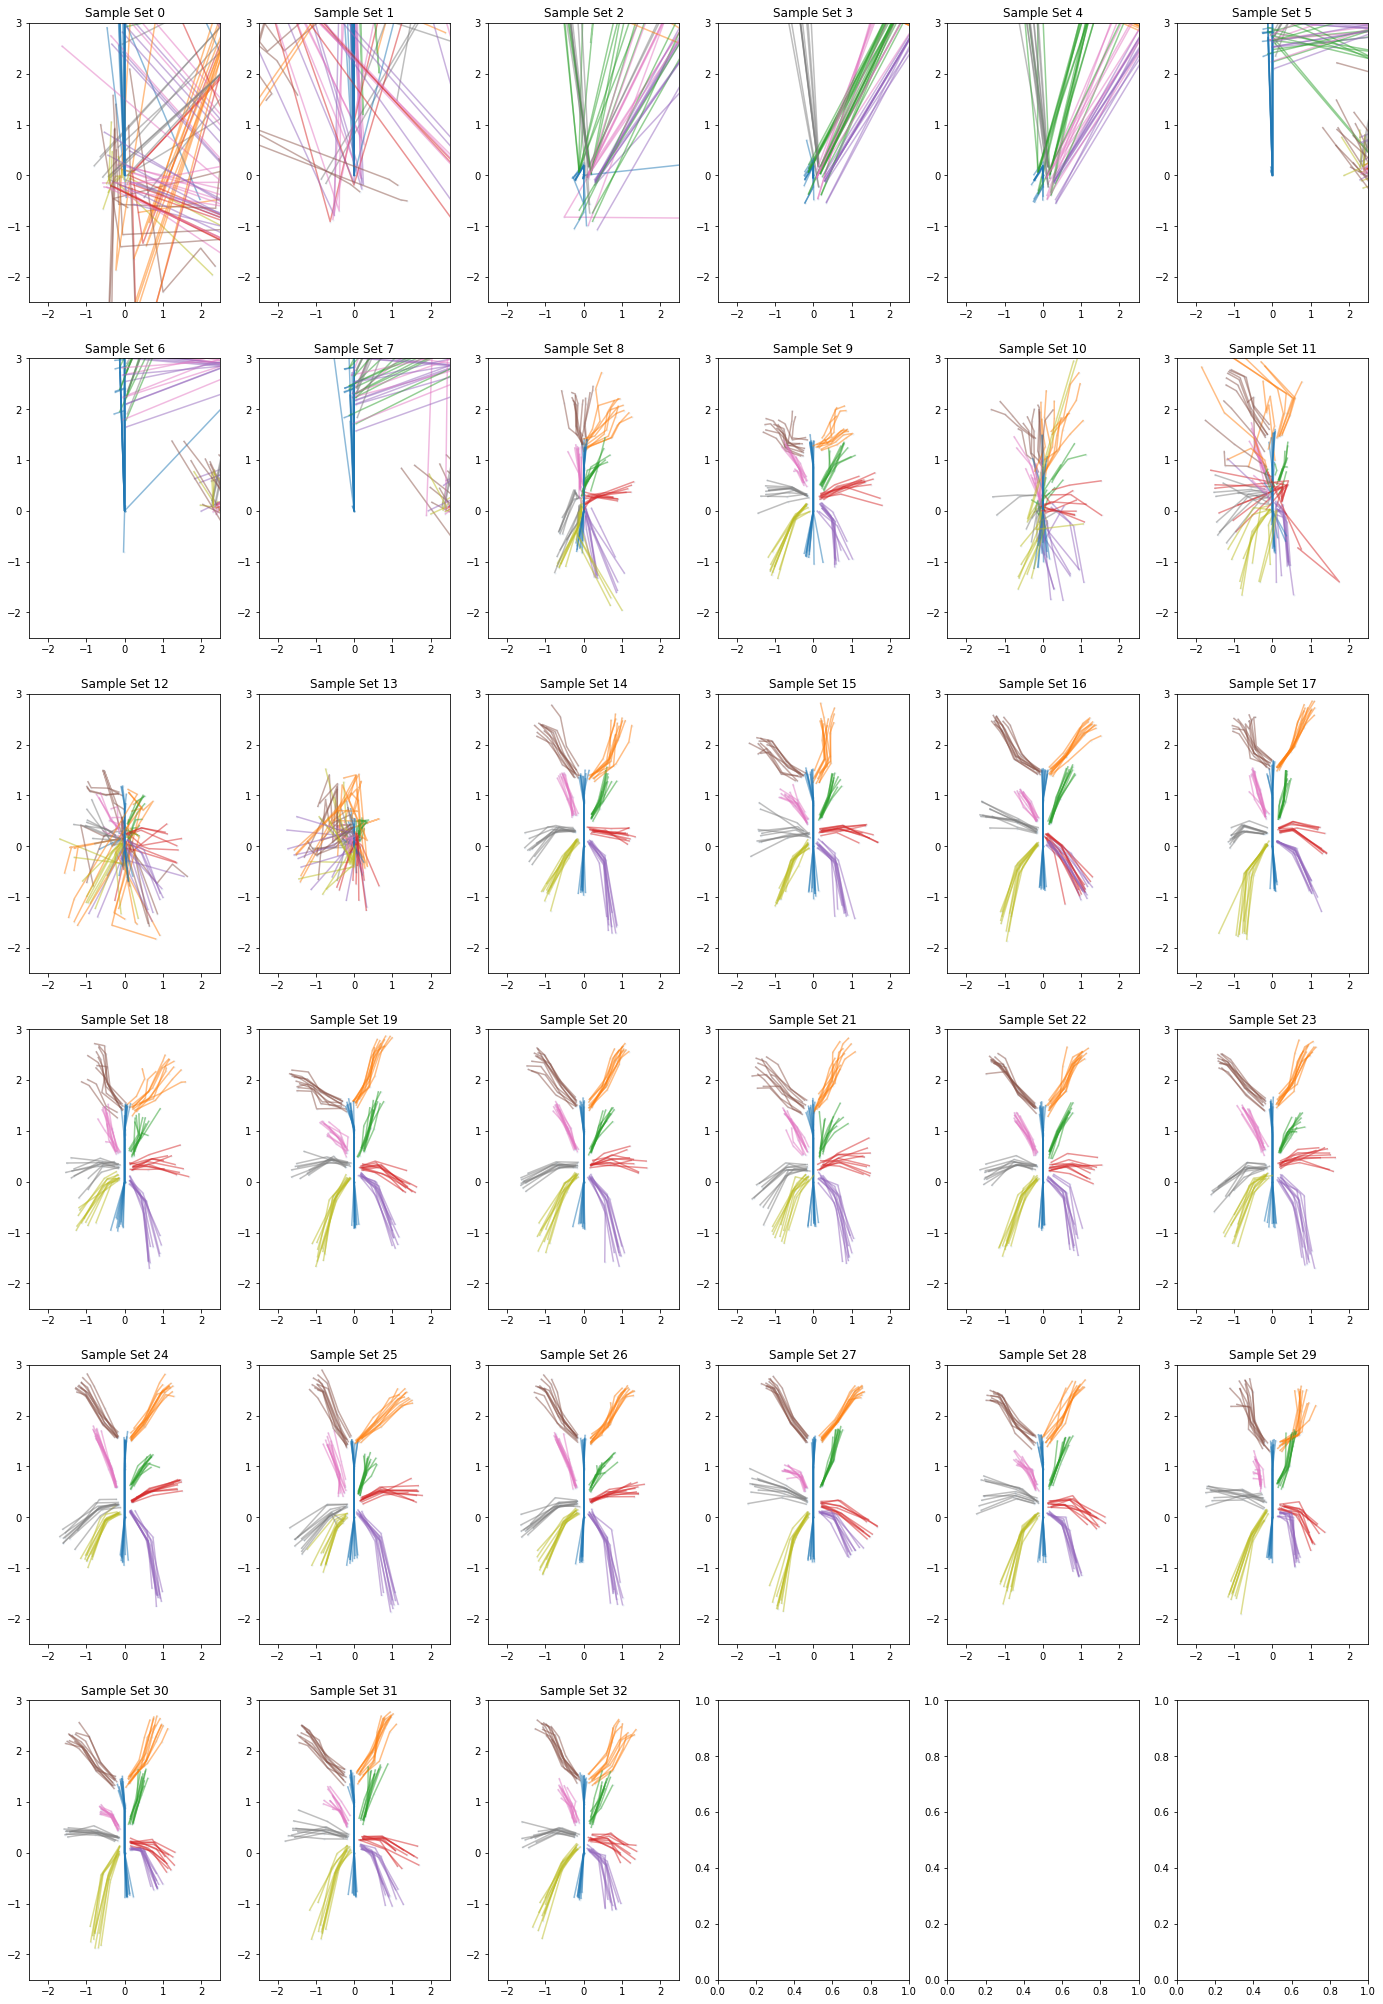

In [143]:
from sklearn.metrics import pairwise_distances

num_clusters = np.max(clusterer.labels_)


num_fig_width, num_fig_height = 6,6
fig, ax = plt.subplots(num_fig_width, num_fig_height, figsize=(num_fig_width*4, num_fig_height*6))

for i in range(num_clusters):
    fr_i = np.where(clusterer.labels_ == i)[0]
    fr_i = fr_i[:10]
    ax[i//6, i%6].scatter(filter_dummy_bp_rotate[fr_i,:,0], filter_dummy_bp_rotate[fr_i,:,1], s=2, alpha=0.05)
    ax[i//6, i%6].set(title= f"Sample Set {i}", xlim=(-2.5,2.5), ylim=(-2.5,3.0))
    
    # build skeleton
    for fr in fr_i:
        for skeleton_i, color_i in zip(skeleton, skeleton_color):
            ax[i//6, i%6].plot(filter_dummy_bp_rotate[fr,skeleton_i,0], filter_dummy_bp_rotate[fr,skeleton_i,1], alpha=0.5, c=color_i)
plt.show()

In [106]:
num_fig_width

6